In [1]:
from weighted_conformal_prediction import WeightedConformalPrediction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycox
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import torch
import torchtuples as tt
from pycox.datasets import metabric
from pycox.evaluation import EvalSurv
from pycox.models import CoxPH
np.random.seed(1234)
_ = torch.manual_seed(123)
# from sksurv.metrics import concordance_index_censored,brier_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
# import multiprocess
# from multiprocess import Pool
from pycox.simulations import SimStudyNonLinearNonPH
import seaborn as sns

In [2]:
n = 10000
sim = SimStudyNonLinearNonPH()
data = sim.simulate(n)
df = sim.dict2df(data, True)
df.drop(columns=['event_true','censoring_true'],inplace = True)

In [3]:
df_censor = df[df['event']==1]
df_notcensor = df[df['event']==0]
df_censor_sample = df_censor.sample(n=len(df_notcensor))

In [4]:
df['event'][df['event']==0] = 'censored'
df['event'][df['event']==1] = 'uncensored'

In [5]:
sns.set_palette(sns.color_palette("RdBu_r", 10))


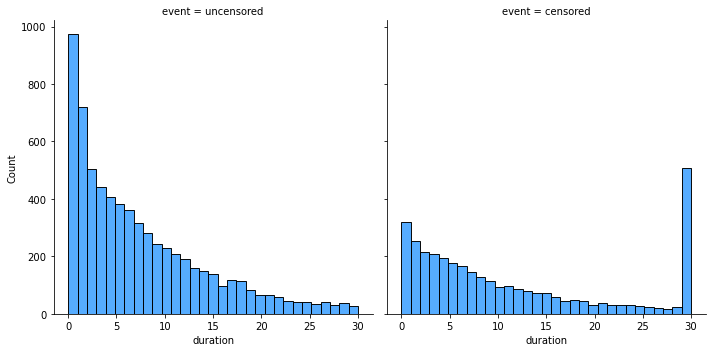

In [6]:
sns.displot(df,x = 'duration',col='event',color = 'dodgerblue')
plt.savefig('shift_2.pdf')

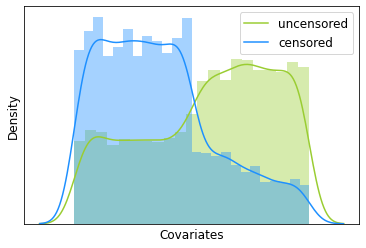

In [9]:
sns.distplot(df_censor['x2'],color='yellowgreen',axlabel=None)
sns.distplot(df_notcensor['x2'],color='dodgerblue',axlabel=None)
plt.legend(['uncensored','censored'],prop={'size':12})
plt.xticks([])
plt.yticks([])
plt.xlabel('Covariates',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.savefig('shift.pdf')

In [2]:
class TwoStageWeightedConformalPrediction():
    def __init__(self,df_1,df_2,train_frac=0.6,calibration_frac=0.2,num_nodes=[32,32],
                 out_features=1,batch_norm=True,
                 batch_size=256,dropout=0.1,output_bias=False,
                 epochs = 512, callbacks = [tt.callbacks.EarlyStopping()],
                 verbose = False,classification_model='LR',
                 percentile = 0.95,epsilon=0.01):
        
        self.df_1 = df_1
        self.df = df_2
        self.train_frac = train_frac
        self.cali_frac = calibration_frac
        self.num_nodes = num_nodes
        self.out_features = out_features
        self.batch_norm = batch_norm
        self.batch_size = batch_size
        self.dropout = dropout
        self.output_bias = output_bias
        self.epochs = epochs
        self.callbacks = callbacks
        self.verbose = verbose
        self.clf_model = classification_model
        self.epsilon = epsilon
        self.percentile = percentile
        self.V = None
        self.W = None
        self.p_hat = None
        self.T_h = None
        self.x_mapper = None
        self.get_target = lambda df: (df['duration'].values, df['event'].values)
        self.bh = None
        self.model = None
        self.wcp = WeightedConformalPrediction(self.df_1,self.train_frac,self.cali_frac,self.num_nodes,
                                               self.out_features,self.batch_norm,self.batch_size,self.dropout,self.output_bias, self.epochs, 
                                               self.callbacks,self.verbose,self.clf_model,
                                               self.percentile,self.epsilon)
        self.wcp.run_training_step()
        self.x_mpper = self.wcp.x_mapper
        self.get_target = self.wcp.get_target
        
        
    def preprocessing(self):
        self.x_ca = self.wcp.x_mapper.transform(self.df).astype('float32')
        self.durations_ca, self.events_ca = self.wcp.get_target(self.df)
        
        self.in_features = self.x_ca.shape[1]
    
    def run_preprocessing(self):
        if self.x_mapper == None:
            self.preprocessing()
            
    def compute_nonconformal_score_single(self,x,t):
        q_h = self.wcp.get_T(x,t)
        q_l = 0
#         print(q_h)
#         print(q_l,q_h,t,q_l-t,t-q_h)
        return (max(q_l-t,t-q_h),q_h)

    def compute_nonconformal_score(self):        
        Z_ca_1 = self.df[self.df['event']==1] # calibration set中发病的样本
        x_ca = self.wcp.x_mapper.transform(Z_ca_1).astype('float32')
        durations_test_1, events_test_1 = self.wcp.get_target(Z_ca_1)
        self.V = list()
        for i in range(len(x_ca)): # nonconformal score
#             print('Data Point %d\t duration:%.2f' % (i,durations_test_1[i]))
            v,q = self.compute_nonconformal_score_single(np.array([x_ca[i]]),durations_test_1[i])
            self.V.append(v)
            
        self.V = np.array(self.V+[np.inf])
    
    def run_compute_nonconformal_score(self):
        if self.V == None:
            self.compute_nonconformal_score()
        
    def compute_weight(self):
#         print('compute weight')
        Z_ca_1 = self.df[self.df['event']==1] # calibration set中发病的样本
        x_ca = self.wcp.x_mapper.transform(Z_ca_1).astype('float32')
        p_predict = self.wcp.clf.predict_proba(x_ca)[:,1] # 预测p_hat
        self.W = np.divide(self.wcp.p_t,p_predict) # 估计w_hat
    
    def run_conpute_weight(self):
        if self.W == None:
            self.compute_weight()
            
    # 计算normalized weight,输入计算的weight，test point，训练过的分类模型
    def compute_normalized_weight(self,x):
        '''
        x: test point
        '''
#         print('compute normalized weight')
        p_predict = self.wcp.clf.predict_proba(x)[0,1] # 预测test point对应的T=1的概率
        w_predict = self.wcp.p_t/p_predict # 估计p_hat
        if p_predict < 0.01:
            p_predict = 0.01
        normalize_term = np.sum(self.W)+w_predict 
#         print(normalize_term,w_predict)
        p_hat = [i/normalize_term for i in self.W] # 计算所有病人的p_hat
        p_inf = w_predict/normalize_term # 计算无穷点的weight
        self.p_hat = np.array(p_hat+[p_inf])
        
    # 计算对应的置信区间，输入nonconformal score, normalized weight p_hat, p_inf,以及指定的percentile
    def compute_quantile(self,x,t):
        V_x,q = self.compute_nonconformal_score_single(x,t)
        p_hat_leave = self.p_hat[self.V<=V_x]
        return (sum(p_hat_leave),q)
    
    def weighted_conformal_prediction(self,x,t_h):
        self.compute_normalized_weight(x)
#         if self.p_hat[-1] > 1-self.percentile:
#             _,q = self.compute_quantile(x,np.inf)
#             return (np.inf,1,q)
#         print(self.p_hat)
#         print('weighted conformal prediction')
        quantile = 0
        t_l = 0
        t_h = 10
        while (quantile<self.percentile):
            t_h = t_h + t_h*(self.percentile-quantile)
            quantile,q = self.compute_quantile(x,t_h)
            
#             print(t_h,quantile)
#         print(quantile)
        quantile_ = quantile
        q_ = q
        t_l = t_h-10
        flag = 0
        
#         while (quantile-self.percentile>self.epsilon):
#             q_ = q
#             quantile_ = quantile
#             quantile,q = self.compute_quantile(x,t_l)
#             if quantile < self.percentile:
#                 flag = 1
#                 break
#             else:
#                 q_ = q
#                 quantile_ = quantile
#             t_l = t_l - 10
#         T_h = t_l + flag*10
        T_h = t_h
#         print(q_)
        return (T_h,quantile_,q_)
    
    def run_training_step(self):
        self.run_preprocessing()
        self.run_compute_nonconformal_score()
        self.run_conpute_weight()
            
    def get_T(self,x,t_h):
        T_h,quantile,q = self.weighted_conformal_prediction(x,t_h)
        return (quantile,T_h,q)
    
    def get_wcp_T(self,x,t_h):
        if self.wcp.T_h is None:
            self.wcp.weighted_conformal_prediction(x,t_h)
        return self.wcp.T_h
    
    def get_nonconformal_score_of_calibration(self):
        if self.V is None:
            self.compute_nonconformal_score()
        return self.V
    
    def get_weight(self):
        if self.W is None:
            self.compute_weight()
        return self.W
    
    def get_normalized_weight(self,x):
        if self.p_hat is None:
            self.compute_normalized_weight(x)
        return self.p_hat
    
    def run_test(self,df_test,i,t_h):
        x = self.wcp.x_mapper.transform(df_test.iloc[i:i+1,:]).astype('float32')
        _,t_h_1,t_h_2 = self.get_T(x,t_h)
        print('[{i}]\t {t_h_1}\t{t_h_2}')
        return (t_h_1,t_h_2)

In [3]:
cores = torch.multiprocessing.cpu_count()
pool = torch.multiprocessing.Pool(processes = cores-20)
try:
    torch.multiprocessing.set_start_method('spawn')
except RuntimeError:
    pass

In [ ]:
# exp_g太大可能是什么原因
kf = KFold(5)
df_data = metabric.read_df()
t_h = np.max(df_data['duration'])
CI_1 = []
CI_2 = []
for train_index,test_index in kf.split(df_data):
    
    df_train = df_data.iloc[train_index,:]
    df_ = df_data.iloc[test_index,:]
    df_ca = df_.sample(frac=0.5)
    df_ = df_.drop(df_ca.index)
    df_test = df_
    print('=='*40)
    print('Initialization')
    tswcp = TwoStageWeightedConformalPrediction(df_train,df_ca,verbose = False,percentile=0.8)
    duration,event = tswcp.wcp.get_target(df_test)
    event = event.astype('bool')
    print('=='*40)
    print('Begin Training')
    tswcp.run_training_step()
    print('=='*40)
    print('Begin Testing')
    print('=='*40)
    a1 = []
    a2 = []
#     input_ = [(df_test,i,t_h) for i in range(len(df_test))]
# #     input_ = zip([tswcp]*len(df_test),[df_test]*len(df_test),range(len(df_test)),[t_h]*len(df_test))
#     results = pool.starmap(tswcp.run_test,input_)
#     a1 = [x[0] for x in results]
#     a2 = [x[1] for x in results]
    for i in range(len(df_test)):
#         print('Data point %d' % i)
        x = tswcp.wcp.x_mapper.transform(df_test.iloc[i:i+1,:]).astype('float32')
        _,t_h_1,t_h_2 = tswcp.get_T(x,t_h)
        print('[%d]\t %.3f\t%.2f\t%.2f'%(i,_,t_h_1,t_h_2))
        a1.append(t_h_1)
        a2.append(t_h_2)
#     a1 = np.array(a1)
    coverage_1 = sum([1 for i in range(len(a1)) if a1[i] >= duration[i]])/len(df_test)
    coverage_2 = sum([1 for i in range(len(a2)) if a2[i] >= duration[i]])/len(df_test)
    print(coverage_1,coverage_2)
    CI_1.append(coverage_1)
    CI_2.append(coverage_2)
#     CI_1.append(concordance_index_censored(event,duration,a1))
#     CI_2.append(concordance_index_censored(event,duration,a2))
# x = np.array([[-0.91468555,1.1301656,-0.47822767,-0.789998,0.7613344,1.,1.,0. ,1.]]).astype('float32')
# print(tswcp.get_T(x,t_h))

Initialization
Preprocessing
Nonconformal Score
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}]
[{i}

In [ ]:
np.mean(CI_1),np.std(CI_1),np.mean(CI_2),np.std(CI_2)

In [ ]:
# df_train = df_data.iloc[train_index,:]
# df_ = df_data.iloc[test_index,:]
# df_ca = df_.sample(frac=0.5)
# df_ = df_.drop(df_ca.index)
# df_test = df_

# tswcp = TwoStageWeightedConformalPrediction(df_train,df_ca,verbose = False,percentile=0.8)
# duration,event = tswcp.wcp.get_target(df_test)
# event = event.astype('bool')
# tswcp.run_training_step()
# x = tswcp.wcp.x_mapper.transform(df_test.iloc[10:10+1,:]).astype('float32')

In [ ]:
# %load_ext line_profiler

In [ ]:
# %lprun -f tswcp.wcp.compute_nonconformal_score_single tswcp.get_T(x,t_h)